In [118]:
# Sql Alchemy Script
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [119]:
import numpy as np
import pandas as pd
from textwrap import wrap

In [120]:
import datetime as dt

In [121]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [122]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [123]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [124]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [125]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [126]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [127]:
# Display the row's columns and data in dictionary format from Measurement
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ab75a0a898>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [128]:
# Display the row's columns and data in dictionary format from Station
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1ab76f42198>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

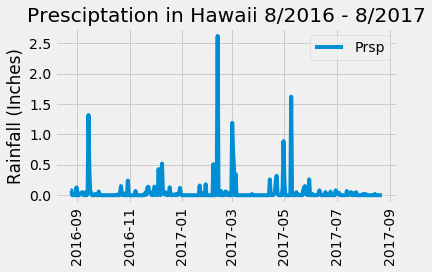

In [129]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date = list(np.ravel(max_date))[0]
        
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d')
#print(max_date)

before_date = max_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

lst_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= before_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
#print(lst_year_prcp)

# Save the query results as a Pandas DataFrame and set the index to the date column
# dropped dates with NAN values
lyp_df = pd.DataFrame(lst_year_prcp).dropna()
lyp_df['date'] = pd.to_datetime(lyp_df['date'])
#print(lyp_df)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(lyp_df['date'], lyp_df['prcp'])
plt.title("Presciptation in Hawaii 8/2016 - 8/2017", horizontalalignment='center')
plt.ylabel('Rainfall (Inches)')
plt.legend(["Prsp"])
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('Output/Prescipitation.png', dpi=fig.dpi)
plt.show()

# Export file as a CSV, without the Pandas index, but with the header
lyp_df.to_csv("Output/Prescipation_data.csv", index=True, header=True)

In [130]:
#  Use Pandas to calcualte the summary statistics for the precipitation data
desc_lyp = lyp_df.describe()
desc_lyp.to_csv("Output/Summary_stats.csv", index=True, header=True)
print(desc_lyp)

             prcp
count  363.000000
mean     0.048843
std      0.205197
min      0.000000
25%      0.000000
50%      0.000000
75%      0.020000
max      2.620000


In [136]:
# Design a query to show how many stations are available in this dataset?
query = session.query(func.count(Station.station)).all()
count = query[0][0]
print(f'There are {count} stations in the dataset')

There are 9 stations in the dataset


In [134]:
# What are the most active stations? (i.e. what stations have the most rows)?
act_stations = [Measurement.station,
               func.count(Measurement.station)]
# List the stations and the counts in descending order.
act_stat_qry = session.query(*act_stations).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
act_stat_qry

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [150]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = engine.execute('SELECT MIN(tobs) from measurement where station = "USC00519281"').fetchall()
low = low_temp[0][0]
round(low)
print(f'The lowest tempature at station USC00519281 was {low}')
high_temp = engine.execute('SELECT MAX(tobs) from measurement where station = "USC00519281"').fetchall()
high = high_temp[0][0]
round(high)
print(f'The highest tempature at station USC00519281 was {high}')
avg_temp = engine.execute('SELECT AVG(tobs) from measurement where station = "USC00519281"').fetchall()
avg = avg_temp[0][0]
avg = round(avg)
print(f'The average tempature at station USC00519281 was {avg}')

The lowest tempature at station USC00519281 was 54.0
The highest tempature at station USC00519281 was 85.0
The average tempature at station USC00519281 was 72


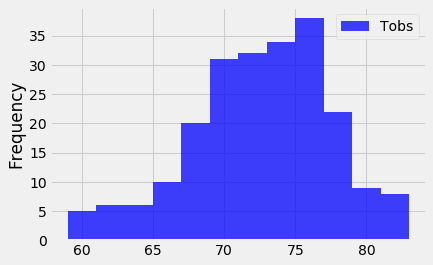

In [162]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = engine.execute('SELECT date, tobs from measurement where station = "USC00519281" and date > "2016-8-23"').fetchall()
temp_12_mnths = pd.DataFrame(temp_obs)
stat_9281 = temp_12_mnths.rename(columns={0: 'Date', 1: 'Tobs'})
#print(stat_9281)
stat_9281.plot.hist(bins=12, alpha=.75, color="b")

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
